In [1]:
from __future__ import division
from __future__ import print_function
import argparse
import functools
import os
import pickle
import matplotlib.pyplot as plt
import random
import shutil
import time
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=125)
parser.add_argument('--neurons', type=int, default=100)
args, unknown = parser.parse_known_args()
epochs = args.epochs
epochs = 400


In [3]:
# helper class
def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return wrapper

In [4]:
class DCRNN_MODEL:

    def __init__(self, data, target, dropout, num_layers, is_training, timesteps=128):
        self.data = data
        self.target = target
        self.dropout = dropout
        self.num_layers = num_layers
        self.is_training = is_training
        self._num_hidden = args.neurons        
        self._timesteps = timesteps
        self.prediction
        self.error
        self.optimize
        self.accuracy
        self.predProbs

    @lazy_property
    def prediction(self):
        # CNN part
        input_layer = tf.reshape(self.data, [-1, self._timesteps, FEATURES, 1])
        conv1 = tf.compat.v1.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, FEATURES], strides=1, activation=tf.nn.relu, padding='SAME')
        pool1 = tf.compat.v1.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=1)
        print(pool1.shape,self.is_training)
        rate=0.5 if self.is_training==True else 1
 

        pool1 = tf.compat.v1.nn.dropout(pool1, rate)
    
        conv2 = tf.compat.v1.layers.conv2d(inputs=pool1, filters=16, kernel_size=[3, 3], strides=1, activation=tf.nn.relu, padding='SAME')
        pool2 = tf.compat.v1.layers.max_pooling2d(inputs=conv2, pool_size=[1, 8], strides=1)        
        last_pool_shape = pool2.get_shape().as_list()
        pool2_flat = tf.reshape(pool2, [-1, last_pool_shape[1], last_pool_shape[2]*last_pool_shape[3]])
        rate=0.5 if self.is_training==True else 1.0
        pool2_flat = tf.nn.dropout(pool2_flat,rate )
   
        # concatenating CNN output and input
        pool2_flat_extended = tf.concat([pool2_flat, self.data], axis=2)
        print(self._num_hidden)
        # Recurrent network.

        stacked_rnn = []
        for i in range(self.num_layers):
            cell = tf.compat.v1.nn.rnn_cell.GRUCell(num_units=self._num_hidden)
            cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=1.0-self.dropout[i])
            stacked_rnn.append(cell)            
        network = tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)
        
        x = tf.unstack(pool2_flat_extended, last_pool_shape[1], 1)
        output, _ =tf.compat.v1.nn.static_rnn(network, x, dtype=tf.float32)

        # Softmax layer parameters
        dense  = tf.compat.v1.layers.dense(inputs=output[-1], units=self._num_hidden, activation=None)
        dense  = tf.compat.v1.layers.batch_normalization(dense, center=True, scale=True, training=self.is_training)
        dense  = tf.nn.dropout(dense, (0.5 if self.is_training==True else 1))
        logits = tf.compat.v1.layers.dense(inputs=dense, units=int(self.target.get_shape()[1]), activation=None)
        soft_reg = tf.nn.softmax(logits)
              
        return soft_reg, output[-1]
    
    @lazy_property
    def cost(self):
        soft_reg, _ = self.prediction
        cross_entropy =tf.math.reduce_mean(-tf.math.reduce_sum(self.target * tf.math.log(soft_reg)))  
        return cross_entropy

    @lazy_property
    def optimize(self):
        optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=0.00005, momentum=0.9, epsilon=1e-6)            
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        soft_reg, _ = self.prediction
        mistakes = tf.math.not_equal(tf.math.argmax(self.target, 1), tf.math.argmax(soft_reg, 1))
        return tf.math.reduce_mean(tf.cast(mistakes, tf.float32))
    
    @lazy_property
    def accuracy(self):
        soft_reg, pool2_flat = self.prediction
        correct_pred = tf.math.equal(tf.math.argmax(self.target, 1), tf.math.argmax(soft_reg, 1))
        return tf.math.reduce_mean(tf.cast(correct_pred, tf.float32)), pool2_flat
        
    @lazy_property
    def predProbs(self):
        soft_reg, _ = self.prediction
        softmax_prob = soft_reg
        return softmax_prob

In [5]:
# load pre-built feature matrices
def load_data(file):
    trip_segments = np.load(file)
    print("Number of samples: {}".format(trip_segments.shape[0]))
    return trip_segments
        

# to split data to train, dev, and test; default: 75% train, 10% dev, and 15% test
def returnTrainDevTestData():

    matrices = load_data('data/RandomSample_5_10.npy')
    keys = pickle.load(open('data/RandomSample_5_10.pkl', 'rb'))
        
    FEATURES = matrices.shape[-1]    
    
    #Build Train, Dev, Test sets
    train_data = []
    train_labels = []
    dev_data = []
    dev_labels = []
    test_data = []
    test_labels = []
    test_tripId = []
    
    curTraj = ''
    assign = ''
    
    driverIds = {}
    
    for idx in range(len(keys)):
        d,t = keys[idx]
        if d in driverIds:
            dr = driverIds[d]
        else: 
            dr = len(driverIds)
            driverIds[d] = dr            
        m = matrices[idx][1:129,]
        if t != curTraj:
            curTraj = t
            r = random.random()
        if r < 0.75: 
            train_data.append(m)
            train_labels.append(dr)
        elif r < 0.85: 
            dev_data.append(m)
            dev_labels.append(dr)
        else: 
            test_data.append(m)
            test_labels.append(dr)      
            test_tripId.append(t)

    train_data   = np.asarray(train_data, dtype="float32")
    train_labels = np.asarray(train_labels, dtype="int32")
    dev_data   = np.asarray(dev_data, dtype="float32")
    dev_labels = np.asarray(dev_labels, dtype="int32")
    test_data    = np.asarray(test_data, dtype="float32")
    test_labels  = np.asarray(test_labels, dtype="int32")
    
    rng_state = np.random.get_state()
    np.random.set_state(rng_state)
    np.random.shuffle(train_data)
    np.random.set_state(rng_state)
    np.random.shuffle(train_labels)
  
    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels, test_tripId, len(driverIds), FEATURES 

    
def convertLabelsToOneHotVector(labels, ln):
    tmp_lb = np.reshape(labels, [-1,1])
    next_batch_start = 0
    _x = np.arange(ln)
    _x = np.reshape(_x, [-1, 1])
    enc = OneHotEncoder()
    enc.fit(_x)
    labels =  enc.transform(tmp_lb).toarray()
    return labels
  

def returnTripLevelAccuracy(test_labels, test_tripId, probabilities, num_classes):    
    lbl = ''
    probs = []
    correct = total = 0
    for i in range(len(test_labels)):        
        if lbl == test_tripId[i]:
            probs.append(probabilities[i])
        else:
            if len(probs) > 0:
                total += 1.0
                probs = np.asarray(probs)
                probs = np.mean(probs, axis=0)
                probs = (probs/np.max(probs)).astype(int)
                if np.sum(probs&test_labels[i-1].astype(int)) == 1: correct += 1
            probs = []
            probs.append(probabilities[i])
            lbl = test_tripId[i]
    if len(probs) > 0:
        total += 1.0
        probs = np.asarray(probs)
        probs = np.mean(probs, axis=0)
        probs = (probs/np.max(probs)).astype(int)      
        if np.sum(probs&test_labels[len(test_labels)-1].astype(int))==1: correct += 1
        
    return correct/total

In [6]:
if __name__ == '__main__':
    ITERATIONS = 1  # number of times to repeat the experiment 
ALL_SEG_ACC = []
ALL_TRP_ACC = []
accuracy_list = []

for IT in range(0, ITERATIONS):
    tf.compat.v1.reset_default_graph()
    print ('\n\n************ Iteration: {} ************\n'.format(IT+1))
            
    st = time.time()
    train, train_labels, dev, dev_labels, test, test_labels, test_tripId, num_classes, FEATURES = returnTrainDevTestData()
    print('Train, Test datasets are loaded in {:.1f} seconds!'.format(time.time()-st))
    print('There are {} samples in train, {} in dev, and {} in test set!'.format(len(train), len(dev), len(test)))
    print('num_classes', num_classes)    
    
    display_step = 50
    training_steps = 1000000
    batch_size = 256
    
    timesteps = 128 # Number of rows in Matrix of a Segment
    num_layers = 2 # Number of network layers
    dropouts_train = [0.0, 0.5] #dropout values for different network layers [for train]
    dropouts_dev  = [0.0, 0.0] #dropout values for different network layers [for test and dev]

    train_labels = convertLabelsToOneHotVector(train_labels, num_classes)   
    dev_labels = convertLabelsToOneHotVector(dev_labels, num_classes)   
    test_labels = convertLabelsToOneHotVector(test_labels, num_classes)            
    
    tf.compat.v1.disable_eager_execution()
    data = tf.compat.v1.placeholder(tf.float32, [None, 128, FEATURES])    
    target = tf.compat.v1.placeholder(tf.float32, [None, num_classes])
    dropout = tf.compat.v1.placeholder(tf.float32, [len(dropouts_train)])    
    is_training = tf.compat.v1.placeholder(tf.bool)    
    model = DCRNN_MODEL(data, target, dropout, num_layers, is_training=True)
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    
    train_start = time.time()
    start = time.time()
    next_batch_start = 0
    
    saver = tf.compat.v1.train.Saver() #This is the saver of the model    
    
    maxTestAccuracy = 0.0 #This will be used as a constraint to save the best model
    bestEpoch = 0    
    steps_to_epoch = len(train)/batch_size
     
    model_name = 'models/DCRNN/'        
    if os.path.exists(model_name):
        shutil.rmtree(model_name)            
    os.makedirs(model_name)
    
    for step in range(training_steps):
        idx_end = min(len(train),next_batch_start+batch_size)        
        sess.run(model.optimize, {data: train[next_batch_start:idx_end,:], target: train_labels[next_batch_start:idx_end,:], dropout: dropouts_train, is_training:True})
        
        epoch = int(step/steps_to_epoch)
        if epoch>epochs: break #epochs: maximum possible epochs
        
        if epoch > bestEpoch or epoch == 0:
            acc,_ = sess.run(model.accuracy, {data: dev, target: dev_labels, dropout: dropouts_dev, is_training:False})
            accuracy_list.append(acc)
            if epoch > 5 and acc > maxTestAccuracy:
                maxTestAccuracy = acc
                bestEpoch = epoch
                save_path = saver.save(sess, model_name)
                print('Model saved in path: {}, Accuracy: {:.2f}%, Epoch: {:d}'.format(save_path, 100*acc, epoch))
        
        if step % display_step == 0:
            loss_train = sess.run(model.cost, {data: train[next_batch_start:idx_end,:], target: train_labels[next_batch_start:idx_end,:], dropout: dropouts_dev, is_training:False})
            loss_dev = sess.run(model.cost, {data: dev, target: dev_labels, dropout: dropouts_dev, is_training:False})
            acc_train,pool2_flat  = sess.run(model.accuracy, {data: train[next_batch_start:idx_end,:], target: train_labels[next_batch_start:idx_end,:], dropout: dropouts_dev, is_training:False})
            acc_dev,_  = sess.run(model.accuracy, {data: dev, target: dev_labels, dropout: dropouts_dev, is_training:False})
            print('Step {:2d}, Epoch {:2d}, Minibatch Train Loss {:.3f}, Dev Loss {:.3f}, Train-Accuracy {:.1f}%, Dev-Accuracy {:.1f}% ({:.1f} sec)'.format(step + 1, epoch, loss_train, loss_dev, 100 * acc_train, 100*acc_dev, (time.time()-start)))
            start = time.time()
                            
        next_batch_start = next_batch_start+batch_size
        if next_batch_start >= len(train):                
            rng_state = np.random.get_state()
            np.random.set_state(rng_state)
            np.random.shuffle(train)
            np.random.set_state(rng_state)
            np.random.shuffle(train_labels)
            next_batch_start = 0
    
    
    print("Optimization Finished!")
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, model_name)        
  
    accuracy,_ = sess.run(model.accuracy, {data: test, target: test_labels, dropout: dropouts_dev, is_training:False})
    # calculate trip-level prediction accuracy
    probabilities = sess.run(model.predProbs, {data: test, target: test_labels, dropout: dropouts_dev, is_training:False})
    trip_level_accuracy = returnTripLevelAccuracy(test_labels, test_tripId, probabilities, num_classes)        
        
    print('Test-Accuracy(segment): {:.2f}%, Test-Accuracy(trip): {:.2f}%,Train-Time: {:.1f}sec'.format(accuracy*100, trip_level_accuracy*100, (time.time()-train_start)))
    print('Partial Best Test-Accuracy: {:.2f}%, Best Epoch: {}'.format(maxTestAccuracy*100, bestEpoch))
    
    ALL_SEG_ACC.append(accuracy*100)
    ALL_TRP_ACC.append(trip_level_accuracy*100)
    

print ('\n\nAll Iterations are completed!')
print ('Average Segment Accuracy: {:.2f}%, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}'.format(np.mean(ALL_SEG_ACC), np.std(ALL_SEG_ACC), np.min(ALL_SEG_ACC), np.max(ALL_SEG_ACC)))
print ('Average Trip Accuracy: {:.2f}%, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}'.format(np.mean(ALL_TRP_ACC), np.std(ALL_TRP_ACC), np.min(ALL_TRP_ACC), np.max(ALL_TRP_ACC)))




************ Iteration: 1 ************

Number of samples: 387
Train, Test datasets are loaded in 0.0 seconds!
There are 303 samples in train, 29 in dev, and 55 in test set!
num_classes 5
(None, 128, 28, 16) True
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:21: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, FEATURES], strides=1, activation=tf.nn.relu, padding='SAME')
C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:22: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.compat.v1.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=1)
C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(inputs=pool1, filters=16, kernel_size=[3, 3], strides=1, activation=tf.nn.relu, padding='SAME')
C:\Users\91986\AppDat

100
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:52: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense  = tf.compat.v1.layers.dense(inputs=output[-1], units=self._num_hidden, activation=None)
C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:53: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  dense  = tf.compat.v1.layers.batch_normalization(dense, center=True, scale=True, training=self.is_training)


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\91986\AppData\Local\Temp\ipykernel_22096\2222569000.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(inputs=dense, units=int(self.target.get_shape()[1]), activation=None)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Step  1, Epoch  0, Minibatch Train Loss 796.981, Dev Loss 96.762, Train-Accuracy 16.8%, Dev-Accuracy 20.7% (57.0 sec)
Model saved in path: models/DCRNN/, Accuracy: 17.24%, Epoch: 6
Model saved in path: models/DCRNN/, Accuracy: 34.48%, Epoch: 12
Step 51, Epoch 42, Minibatch Train Loss 587.369, Dev Loss 59.847, Train-Accuracy 27.7%, Dev-Accuracy 37.9% (197.6 sec)
Model saved in path: models/DCRNN/, Accuracy: 37.93%, Epoch: 44
Model saved in path: models/DCRNN/, Accuracy: 44.83%, Epoch: 65
Model saved in path: models/DCRNN/, Accuracy: 51.72%, Epoch: 70
Step 101, Epoch 84, Minibatch Train Loss 417.888, Dev Loss 61.461, Train-Accuracy 37.9%, Dev-Accuracy 13.8% (213.2 sec)
Model saved in path: models/DCRNN/, Accuracy: 62.07%, Epoch: 119
Model saved in path: models/DCRNN/, Accuracy: 68.97%, Epoch: 125
Step 151, Epoch 126, Minibatch Train Loss 257.679, Dev Loss 39.585, Train-Ac

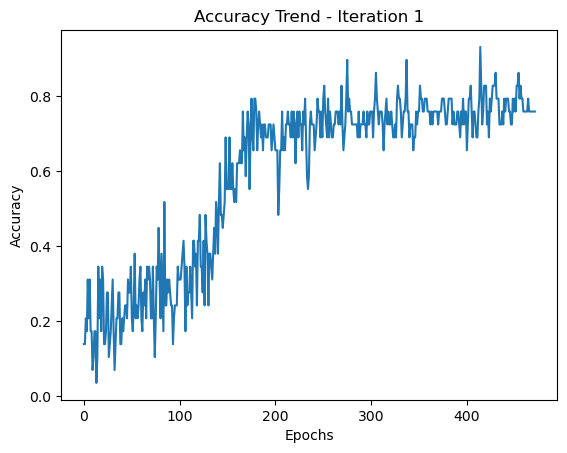

In [7]:
acc_len = len(accuracy_list)
div = int(acc_len/ITERATIONS)
plt.plot(accuracy_list[:div])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Trend - Iteration 1")
plt.show()
